# Map Making

In this lesson we cover the mapmaking problem and current and available TOAST mapmaking facilities
* `OpMadam` -- interface to `libMadam`, a parallel Fortran library for destriping and mapping signal
* `OpMapmaker` -- nascent implementation of a native TOAST mapmaker with planned support for a host of systematics templates

In [1]:
# Are you using a special reservation for a workshop?
# If so, set it here:
nersc_reservation = "toast3"

# Load common tools for all lessons
import sys
sys.path.insert(0, "..")
from lesson_tools import (
    check_nersc,
    fake_focalplane
)
nersc_host, nersc_repo, nersc_resv = check_nersc(reservation=nersc_reservation)

# Capture C++ output in the jupyter cells
%reload_ext wurlitzer


Running on NERSC machine 'cori'
  with access to repos: mp107
Using default repo mp107


## Mapmaking basics

(Apologies to the experts.  You can freely skip the basics if this is trivial to you)

### Binning a map

CMB experiments measure the Stokes I (intensity), Q and U linear polarization components in discrete sky pixels.  A detector pointed at sky pixels $p$ registers a linear combination of the three Stokes components:

$$
d_p = I_p + \eta \cdot (Q_p \cos 2\psi + U_p \sin 2\psi) + n,
$$

where $\eta$ is the polarization efficiency of the detector, $\psi$ is the polarization sensitive direction and $n$ is the noise.  $\psi$ depends on the intrinsic polarization angle of the detector, $\psi_0$, and the relative orientation of the focalplane and the sky, $\psi'$. Furthermore, if the detector is observing the sky through a half-wave plate (HWP), then the HWP angle, $\omega$ must also be accounted for:

$$
\psi = \psi_0 + \alpha + 2\omega
$$

Regardless of how $\psi$ is modulated ($\psi_0$, $\alpha$ or $\omega$), one needs a bare minimum of 3 observations at different angles, $\psi$, to solve for $m=[I, Q, U]^T$. We encode the pointing weights ($1$, $\eta\cdot\cos 2\psi$, $\eta\cdot\sin 2\psi$) in a pointing matrix:

$$
P = \begin{bmatrix}
1 & \eta\cos 2\psi_1 & \eta\sin 2\psi_1 \\
1 & \eta\cos 2\psi_2 & \eta\sin 2\psi_2 \\
 & ... & \\
1 & \eta\cos 2\psi_N & \eta\sin 2\psi_N \\
\end{bmatrix}
$$

A vector of samples drawn from $m$ is then

$$
d = P m
$$

and we can find a (generalized) least squares solution of $m$ as

$$
m = (P^T N^{-1} P)^{-1} P^T N^{-1} d,
$$

where we have accounted for non-trivial noise correlations in

$$
N = \langle n n^T \rangle.
$$

If each detector sample is subject to same, uncorrelated noise fluctuations, $N$ can be dropped.  This recovers the regular least squares solution.

An important special case of $P$ results when the angles $\psi$ differ by 45 degrees and come in sets of 4:

In [2]:
import numpy as np
psi = np.radians(np.arange(4) * 45)
print("psi =", np.round(psi, 2))
P = np.vstack([np.ones_like(psi), np.cos(2*psi), np.sin(2*psi)]).T
print("P = \n", np.round(P, 3))
invcov = np.dot(P.T, P)
print("P^T P = \n", np.round(invcov, 3))
cov = np.linalg.inv(invcov)
print("(P^T P)^{-1} = \n", np.round(cov, 3))

psi = [0.   0.79 1.57 2.36]
P = 
 [[ 1.  1.  0.]
 [ 1.  0.  1.]
 [ 1. -1.  0.]
 [ 1. -0. -1.]]
P^T P = 
 [[ 4. -0.  0.]
 [-0.  2.  0.]
 [ 0.  0.  2.]]
(P^T P)^{-1} = 
 [[ 0.25  0.   -0.  ]
 [ 0.    0.5  -0.  ]
 [-0.   -0.    0.5 ]]


The quantity $P^T P$ is proportional to the noise covariance between $IQU$.  It being diagonal means that the statistical error between them is uncorrelated.  The reciprocal condition number of the above matrix is 0.5 which is the theoretical maximum. Low condition number would indicate that the $IQU$ solution is degenerate.

The mapmaking formalism in this section can be generalised for multiple sky pixels.  Each sky pixel corresponds to its own $I$, $Q$ and $U$ columns in $P$.  If the noise matrix, $N$, is diagonal, the pixel covariance matrix, $P^T N^{-1} P$ is $3\times 3$ block diagonal with each pixel being solved independently.

### Destriping

[arXiv:0907.0367](https://arxiv.org/abs/0907.0367)

In its simplest form, the time-ordered data (TOD) can be described as sky signal and a noise term:

$$
d = Pm + n.
$$

An optimal solution of $m$ requires the sample-sample covariance of $n$.  For that to exist, the noise term needs to be stationary, which is often not the case in presence of systematics.  We may decompose $n$ into a set of systematics templates and the actual, stationary noise term:

$$
d = Pm + Fa + n.
$$

Maximum likelihood solution of the template amplitudes, $a$, follows from the *destriping equation*: 

$$
(F^T N^{-1} Z F + C_a^{-1})a = F^T N^{-1} Z d,
$$

where

$$
Z = \mathbf 1 - P(P^T N^{-1} P)^{-1} P^T N^{-1}
$$

is a projection matrix that removes the sky-synchronous part of the signal and

$$
C_a = \langle a a^T \rangle
$$

TOAST provides an interface to a destriping library, [libMadam](https://github.com/hpc4cmb/libmadam), which solves a version of the destriping equation where the templates in $F$ are disjoint steps of a step function. `libMadam` approximates that the covariance between the steps is stationary and can be calculated from the detector noise power spectral densities (PSDs). The remaining noise term, $n$ is approximated as white noise with a diagonal noise covariance, $N$.  Users can just have `libMadam` write out the destriped maps or continue processing the destriped TOD:

$$
d' = d - Fa
$$

The TOAST native mapmaker under development is designed to be more general.  Columns of the template matrix, $F$ can be populated with arbitrary forms, with or without an associated noise prior term, $C_a$.  The templates are MPI-aware so a template may span data across process boundaries (think orbital dipole or far sidelobes).

## Example

In this section we create a TOAST data object with simulated signal and noise and process the data into hit maps, pixels noise matrices and signal maps.

In [3]:
import toast
import toast.todmap
from toast.mpi import MPI

import numpy as np
import matplotlib.pyplot as plt

mpiworld, procs, rank = toast.mpi.get_world()
comm = toast.mpi.Comm(mpiworld)

# A pipeline would create the args object with argparse

class args:
    sample_rate = 10  # Hz
    hwp_rpm = None
    hwp_step_deg = None
    hwp_step_time_s = None
    spin_period_min = 1 # 10
    spin_angle_deg = 20 # 30
    prec_period_min = 100 # 50
    prec_angle_deg = 30 # 65
    coord = "E"
    nside = 64
    nnz = 3
    outdir = "maps"

# Create a fake focalplane, we could also load one from file.
# The Focalplane class interprets the focalplane dictionary
# created by fake_focalplane() but it can also load the information
# from file.

focalplane = fake_focalplane(samplerate=args.sample_rate, fknee=0.1, alpha=2)
detectors = sorted(focalplane.keys())
detquats = {}
for d in detectors:
    detquats[d] = focalplane[d]["quat"]
    
nsample = 100000
start_sample = 0
start_time = 0
iobs = 0
    
tod = toast.todmap.TODSatellite(
    comm.comm_group,
    detquats,
    nsample,
    coord=args.coord,
    firstsamp=start_sample,
    firsttime=start_time,
    rate=args.sample_rate,
    spinperiod=args.spin_period_min,
    spinangle=args.spin_angle_deg,
    precperiod=args.prec_period_min,
    precangle=args.prec_angle_deg,
    detranks=comm.group_size,
    hwprpm=args.hwp_rpm,
    hwpstep=args.hwp_step_deg,
    hwpsteptime=args.hwp_step_time_s,
)

# Constantly slewing precession axis                                                                                                                                             
precquat = np.empty(4 * tod.local_samples[1], dtype=np.float64).reshape((-1, 4))
toast.todmap.slew_precession_axis(
    precquat,
    firstsamp=start_sample + tod.local_samples[0],
    samplerate=args.sample_rate,
    degday=360.0 / 365.25,
)
tod.set_prec_axis(qprec=precquat)

noise = toast.pipeline_tools.get_analytic_noise(args, comm, focalplane)

obs = {}
obs["name"] = "science_{:05d}".format(iobs)
obs["tod"] = tod
obs["intervals"] = None
obs["baselines"] = None
obs["noise"] = noise
obs["id"] = iobs

data = toast.Data(comm)
data.obs.append(obs)

Create a synthetic Gaussian map to scan as input signal

Sigma is 382.194810 arcmin (0.111176 rad) 
-> fwhm is 900.000000 arcmin


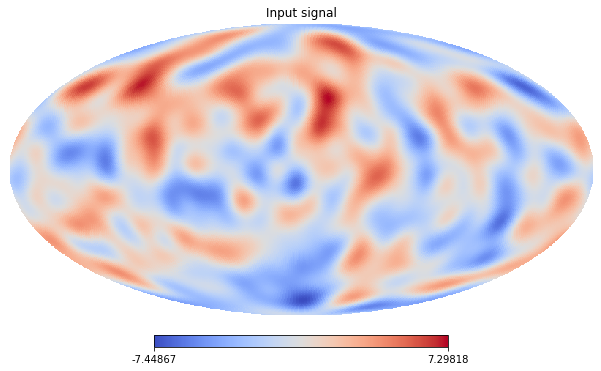

In [4]:
import healpy as hp
lmax = args.nside * 2
cls = np.zeros([4, lmax + 1])
cls[0] = 1e0
sim_map = hp.synfast(cls, args.nside, lmax=lmax, fwhm=np.radians(15), new=True)
hp.mollview(sim_map[0], cmap="coolwarm", title="Input signal")
hp.write_map("sim_map.fits", hp.reorder(sim_map, r2n=True), nest=True, overwrite=True)

Now simulate sky signal and noise

In [5]:
name = "signal"
toast.tod.OpCacheClear(name).exec(data)

toast.todmap.OpPointingHpix(nside=args.nside, nest=True, mode="IQU").exec(data)

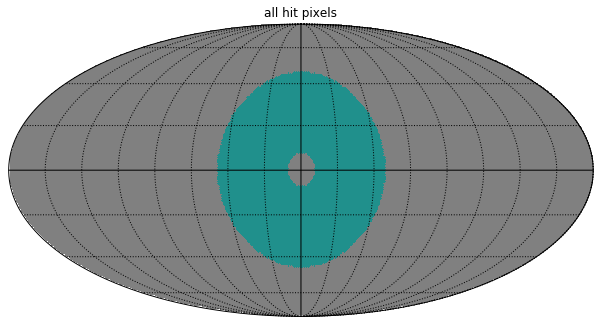

In [6]:
npix = 12 * args.nside ** 2
hitmap = np.zeros(npix)
tod = data.obs[0]["tod"]
for det in tod.local_dets:
    pixels = tod.cache.reference("pixels_{}".format(det))
    hitmap[pixels] = 1
hitmap[hitmap == 0] = hp.UNSEEN
hp.mollview(hitmap, nest=True, title="all hit pixels", cbar=False)
hp.graticule(22.5, verbose=False)

In [7]:
# Scan the signal from a map

localpix, localsm, subnpix = toast.todmap.get_submaps_nested(data, args.nside, subnside=1)
distmap = toast.map.DistPixels(
    comm=mpiworld,
    size=12 * args.nside **2,
    nnz=3,
    dtype=np.float32,
    submap=subnpix,
    local=localsm,
)
distmap.read_healpix_fits("sim_map.fits")
toast.todmap.OpSimScan(distmap=distmap, out=name).exec(data)

# Copy the sky signal

toast.tod.OpCacheCopy(input=name, output="sky_signal", force=True).exec(data)

# Simulate noise

toast.tod.OpSimNoise(out=name, realization=0).exec(data)

toast.tod.OpCacheCopy(input=name, output="full_signal", force=True).exec(data)

Destripe the signal and make a map.  We use the nascent TOAST mapmaker because it can be run in serial mode without MPI.  The TOAST mapmaker is still significantly slower so production runs should used `libMadam`.

In [8]:
mapmaker = toast.todmap.OpMapMaker(
    nside=args.nside,
    nnz=3,
    name=name,
    outdir=args.outdir,
    outprefix="toast_test_",
    # in seconds
    baseline_length=10,
    # maskfile=self.maskfile_binary,
    # weightmapfile=self.maskfile_smooth,
    # subharmonic_order=None,
    iter_max=100,
    use_noise_prior=False,
    # precond_width=30,
)
mapmaker.exec(data)

Plot a segment of the timelines

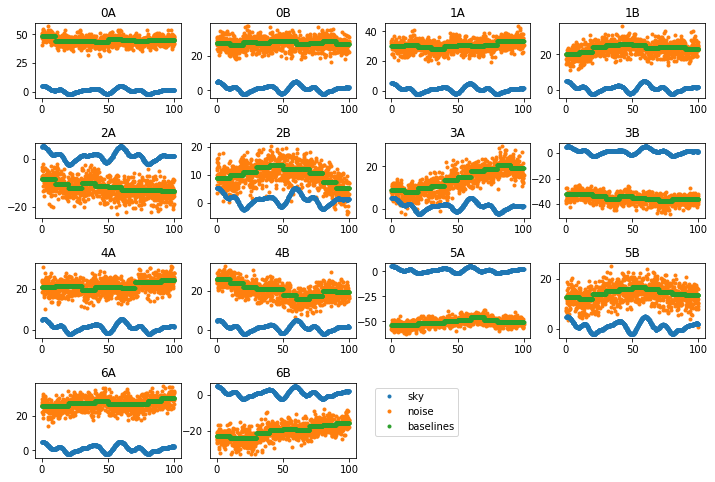

In [9]:
tod = data.obs[0]["tod"]
times = tod.local_times()

fig = plt.figure(figsize=[12, 8])
for idet, det in enumerate(tod.local_dets):
    sky = tod.local_signal(det, "sky_signal")
    full = tod.local_signal(det, "full_signal")
    cleaned = tod.local_signal(det, name)

    ind = slice(0, 1000)
    ax = fig.add_subplot(4, 4, 1 + idet)
    ax.set_title(det)
    ax.plot(times[ind], sky[ind], '.', label="sky", zorder=100)
    ax.plot(times[ind], full[ind] - sky[ind], '.', label="noise")
    ax.plot(times[ind], full[ind] - cleaned[ind], '.', label="baselines")
ax.legend(bbox_to_anchor=(1.1, 1.00))
fig.subplots_adjust(hspace=0.6)


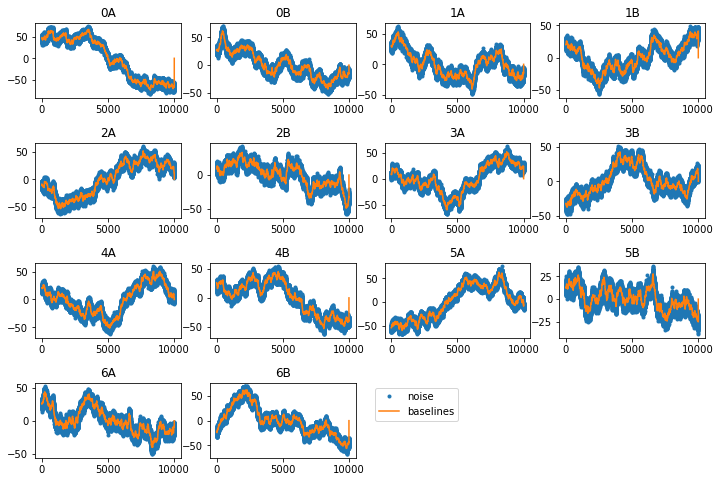

In [10]:
fig = plt.figure(figsize=[12, 8])
for idet, det in enumerate(tod.local_dets):
    sky = tod.local_signal(det, "sky_signal")
    full = tod.local_signal(det, "full_signal")
    cleaned = tod.local_signal(det, name)
    ax = fig.add_subplot(4, 4, 1 + idet)
    ax.set_title(det)
    #plt.plot(times[ind], sky[ind], '-', label="signal", zorder=100)
    plt.plot(times, full - sky, '.', label="noise")
    plt.plot(times, full - cleaned, '-', label="baselines")
ax.legend(bbox_to_anchor=(1.1, 1.00))
fig.subplots_adjust(hspace=.6)

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


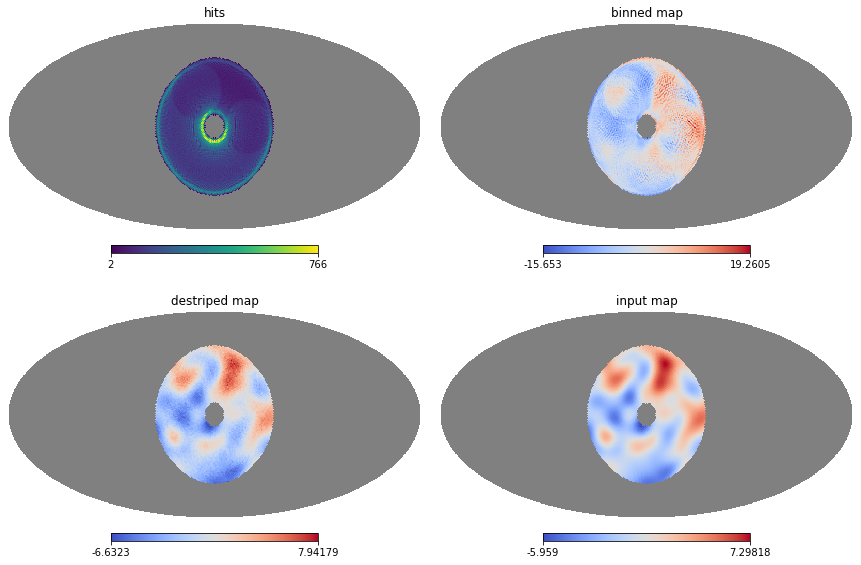

In [11]:
plt.figure(figsize=[12, 8])

hitmap = hp.read_map("maps/toast_test_hits.fits")
hitmap[hitmap == 0] = hp.UNSEEN
hp.mollview(hitmap, sub=[2, 2, 1], title="hits")

binmap = hp.read_map("maps/toast_test_binned.fits")
binmap[binmap == 0] = hp.UNSEEN
hp.mollview(binmap, sub=[2, 2, 2], title="binned map", cmap="coolwarm")

destriped = hp.read_map("maps/toast_test_destriped.fits")
destriped[destriped == 0] = hp.UNSEEN
hp.mollview(destriped, sub=[2, 2, 3], title="destriped map", cmap="coolwarm")

inmap = hp.read_map("sim_map.fits")
inmap[hitmap == hp.UNSEEN] = hp.UNSEEN
hp.mollview(inmap, sub=[2, 2, 4], title="input map", cmap="coolwarm")


In [12]:
print(np.sum(hitmap[hitmap != hp.UNSEEN]) / 1400000.0)

1.0


NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING
Ordering converted to RING


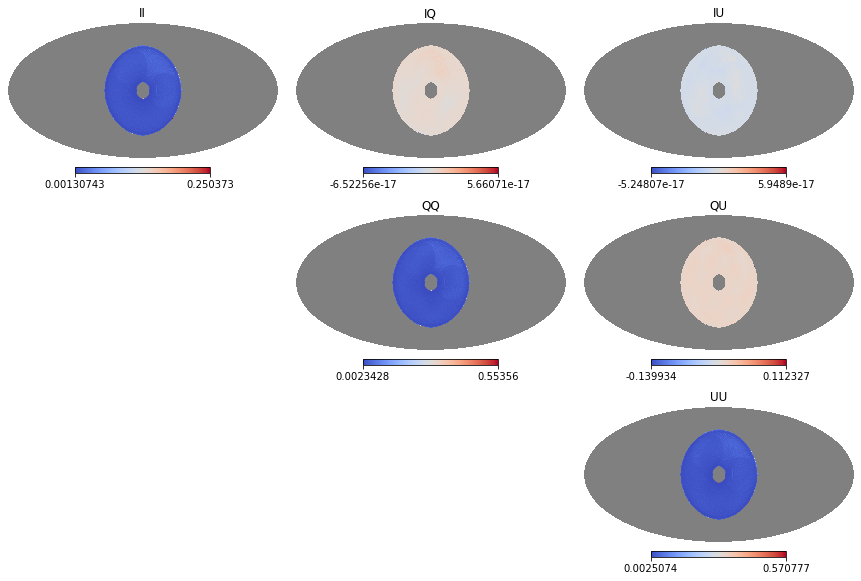

In [13]:
# Plot the white noise covariance

plt.figure(figsize=[12, 8])
wcov = hp.read_map("maps/toast_test_npp.fits", None)
wcov[:, wcov[0] == 0] = hp.UNSEEN
hp.mollview(wcov[0], sub=[3, 3, 1], title="II", cmap="coolwarm")
hp.mollview(wcov[1], sub=[3, 3, 2], title="IQ", cmap="coolwarm")
hp.mollview(wcov[2], sub=[3, 3, 3], title="IU", cmap="coolwarm")
hp.mollview(wcov[3], sub=[3, 3, 5], title="QQ", cmap="coolwarm")
hp.mollview(wcov[4], sub=[3, 3, 6], title="QU", cmap="coolwarm")
hp.mollview(wcov[5], sub=[3, 3, 9], title="UU", cmap="coolwarm")

## Filter & bin

A filter-and-bin mapmaker is easily created by combining TOAST filter operators and running the mapmaker without destriping:

NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING
NSIDE = 64
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT
Ordering converted to RING


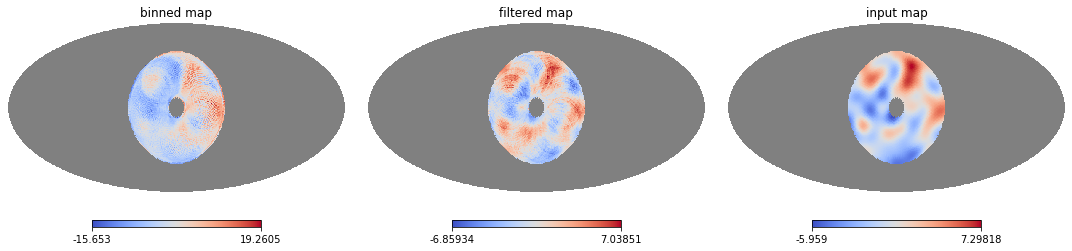

In [14]:
name_in = "full_signal"
name_out = "full_signal_copy"
toast.tod.OpCacheCopy(input=name_in, output=name_out, force=True).exec(data)

toast.tod.OpPolyFilter(order=30, name=name_out).exec(data)

mapmaker = toast.todmap.OpMapMaker(
    nside=args.nside,
    nnz=3,
    name=name_out,
    outdir=args.outdir,
    outprefix="toast_test_filtered_",
    baseline_length=None,
    # maskfile=self.maskfile_binary,
    # weightmapfile=self.maskfile_smooth,
    # subharmonic_order=None,
    iter_max=100,
    use_noise_prior=False,
    # precond_width=30,
)
mapmaker.exec(data)

plt.figure(figsize=[15, 8])
binmap = hp.read_map("maps/toast_test_binned.fits")
filtered_map = hp.read_map("maps/toast_test_filtered_binned.fits")
binmap[binmap == 0] = hp.UNSEEN

hp.mollview(binmap, sub=[1, 3, 1], title="binned map", cmap="coolwarm")
filtered_map[filtered_map == 0] = hp.UNSEEN
hp.mollview(filtered_map, sub=[1, 3, 2], title="filtered map", cmap="coolwarm")

inmap = hp.read_map("sim_map.fits")
inmap[binmap == hp.UNSEEN] = hp.UNSEEN
hp.mollview(inmap, sub=[1, 3, 3], title="input map", cmap="coolwarm")
